# 05_campaign_ranking_reports

## Notebook Purpose
- Compare campaign ranking scores on TEST across multiple top-k fractions (0.1%–10%)
- Evaluate ranking strategies: `p_hat`, `p_cal_*`, `ev`, `ev_cal_*`, and tuned score
- Tune `alpha`/`beta` on VALID for `tuned = (p_hat^alpha) * (rev_hat^beta)` using revenue_capture@1%
- Export reports to `artifacts/reports/`:
  - `topk_report_{score}.csv`, `decile_report_{score}.csv`
  - `revenue_capture_curve_{score}.csv` and `revenue_capture_curve_compare.csv`
  - `alpha_beta_grid.csv`, `alpha_beta_best.csv`

## Context
- Shared inputs/outputs and execution conventions are documented in the project README.

In [1]:
# ============ Common PATH block (local only) ============
from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\seony\Desktop\personal_project\purchase_prediction")

DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
MODELS_DIR = ARTIFACTS_DIR / "models"
PRED_DIR = ARTIFACTS_DIR / "predictions"
REPORTS_DIR = ARTIFACTS_DIR / "reports"
METRICS_DIR = ARTIFACTS_DIR / "metrics"
FIGURES_DIR = ARTIFACTS_DIR / "figures"

for d in [RAW_DIR, PROCESSED_DIR, MODELS_DIR, PRED_DIR, REPORTS_DIR, METRICS_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PRED_DIR:", PRED_DIR)
print("REPORTS_DIR:", REPORTS_DIR)

PROJECT_ROOT: C:\Users\seony\Desktop\personal_project\purchase_prediction
PRED_DIR: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\predictions
REPORTS_DIR: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\reports


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [3]:
# ============ Inputs (from notebook 04) ============
PRED_VALID_CAL = PRED_DIR / "predictions_valid_calibrated.csv"
PRED_TEST_CAL  = PRED_DIR / "predictions_test_calibrated.csv"

assert PRED_VALID_CAL.exists(), f"Missing: {PRED_VALID_CAL}"
assert PRED_TEST_CAL.exists(),  f"Missing: {PRED_TEST_CAL}"

# Top-k fractions (0.1%, 0.5%, 1%, 3%, 5%, 10%)
TOP_FRACS = [0.001, 0.005, 0.01, 0.03, 0.05, 0.10]

# Dense curve for plotting/export
CURVE_FRACS = np.unique(np.concatenate([np.linspace(0.001, 0.10, 50), np.array(TOP_FRACS)])).round(6)

In [4]:
# ============ Load calibrated predictions ============
valid = pd.read_csv(PRED_VALID_CAL)
test  = pd.read_csv(PRED_TEST_CAL)

req = {"user_id", "cutoff", "y_purchase", "y_revenue", "p_hat", "rev_hat", "ev", "p_cal_platt", "p_cal_isotonic", "p_cal", "ev_cal_platt", "ev_cal_isotonic", "ev_cal"}
missing_valid = sorted(list(req - set(valid.columns)))
missing_test  = sorted(list(req - set(test.columns)))
assert not missing_valid, f"VALID missing columns: {missing_valid}"
assert not missing_test,  f"TEST missing columns: {missing_test}"

for df in [valid, test]:
    df["y_purchase"] = df["y_purchase"].astype(int)
    df["y_revenue"]  = df["y_revenue"].astype(float)

print("VALID:", valid.shape, "| base_rate:", float(valid["y_purchase"].mean()), "| revenue_sum:", float(valid["y_revenue"].sum()))
print("TEST :", test.shape,  "| base_rate:", float(test["y_purchase"].mean()),  "| revenue_sum:", float(test["y_revenue"].sum()))
print("Best method label in file (p_cal_method):", str(test["p_cal_method"].iloc[0]))

VALID: (278847, 15) | base_rate: 0.0020656489042378077 | revenue_sum: 207276.36998100005
TEST : (253026, 15) | base_rate: 0.0019760815094101002 | revenue_sum: 218406.91955070003
Best method label in file (p_cal_method): isotonic


In [5]:
# ============ Ranking KPI helpers ============

def topk_report(df: pd.DataFrame, score_col: str, fracs: list[float]) -> pd.DataFrame:
    # Sort with tie-breakers to stabilize ties (important for isotonic)
    sort_cols = [score_col]
    ascending = [False]

    if score_col != "p_hat" and "p_hat" in df.columns:
        sort_cols.append("p_hat")
        ascending.append(False)
    if "rev_hat" in df.columns:
        sort_cols.append("rev_hat")
        ascending.append(False)

    d = df.sort_values(sort_cols, ascending=ascending, kind="mergesort").reset_index(drop=True)

    n = len(d)
    base_rate = float(d["y_purchase"].mean())
    total_buyers = int(d["y_purchase"].sum())
    total_revenue = float(d["y_revenue"].sum())

    rows = []
    for frac in fracs:
        k = int(np.ceil(frac * n))
        k = max(k, 1)

        top = d.iloc[:k]
        buyers = int(top["y_purchase"].sum())
        revenue_sum = float(top["y_revenue"].sum())

        purchase_rate = buyers / k
        buyer_recall = (buyers / total_buyers) if total_buyers > 0 else np.nan
        lift = (purchase_rate / base_rate) if base_rate > 0 else np.nan
        revenue_capture = (revenue_sum / total_revenue) if total_revenue > 0 else np.nan
        revenue_per_user = revenue_sum / k

        rows.append({
            "top_frac": float(frac),
            "k_users": int(k),
            "purchase_rate@k": float(purchase_rate),
            "buyers@k": int(buyers),
            "buyer_recall@k": float(buyer_recall),
            "lift@k": float(lift),
            "revenue_sum@k": float(revenue_sum),
            "revenue_capture@k": float(revenue_capture),
            "revenue_per_user@k": float(revenue_per_user),
        })

    return pd.DataFrame(rows)


def decile_report(df: pd.DataFrame, score_col: str) -> pd.DataFrame:
    # Deciles by score (10 = highest). Use rank() to break ties.
    s = df[score_col].astype(float)
    r = s.rank(method="first", ascending=True)  # 1..n
    dec = pd.qcut(r, 10, labels=False) + 1      # 1..10 (low..high)
    dec = 11 - dec                              # 10..1 (high..low)

    out = df.copy()
    out["decile"] = dec.astype(int)

    g = out.groupby("decile").agg(
        users=("y_purchase", "size"),
        buyers=("y_purchase", "sum"),
        revenue_sum=("y_revenue", "sum"),
        score_mean=(score_col, "mean"),
        score_sum=(score_col, "sum"),
    ).reset_index()

    g["purchase_rate"] = g["buyers"] / g["users"]
    g = g.sort_values("decile", ascending=False).reset_index(drop=True)

    # Column order per spec
    g = g[["decile", "users", "purchase_rate", "buyers", "revenue_sum", "score_mean", "score_sum"]]
    return g


def revenue_capture_curve(df: pd.DataFrame, score_col: str, fracs: np.ndarray) -> pd.DataFrame:
    rep = topk_report(df, score_col=score_col, fracs=list(fracs))
    rep = rep.rename(columns={"revenue_capture@k": "revenue_capture", "purchase_rate@k": "purchase_rate"})
    return rep[["top_frac", "k_users", "revenue_capture", "purchase_rate"]]

In [6]:
# ============ Alpha/Beta tuning on VALID (tuned = (p_hat^alpha) * (rev_hat^beta)) ============
ALPHAS = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0]
BETAS  = [0.25, 0.5, 0.75, 1.0]

def revenue_capture_at(df: pd.DataFrame, score_col: str, top_frac: float) -> float:
    rep = topk_report(df, score_col=score_col, fracs=[top_frac])
    return float(rep.loc[0, "revenue_capture@k"])

def purchase_rate_at(df: pd.DataFrame, score_col: str, top_frac: float) -> float:
    rep = topk_report(df, score_col=score_col, fracs=[top_frac])
    return float(rep.loc[0, "purchase_rate@k"])

grid_rows = []
for a in ALPHAS:
    for b in BETAS:
        tuned = (valid["p_hat"].astype(float) ** a) * (valid["rev_hat"].astype(float) ** b)
        tmp = valid.assign(tuned=tuned)

        cap_1pct = revenue_capture_at(tmp, "tuned", 0.01)
        cap_10pct = revenue_capture_at(tmp, "tuned", 0.10)
        pr_1pct = purchase_rate_at(tmp, "tuned", 0.01)

        grid_rows.append({
            "alpha": float(a),
            "beta": float(b),
            "revenue_capture@1pct_valid": float(cap_1pct),
            "revenue_capture@10pct_valid": float(cap_10pct),
            "purchase_rate@1pct_valid": float(pr_1pct),
        })

grid = pd.DataFrame(grid_rows).sort_values(
    ["revenue_capture@1pct_valid", "revenue_capture@10pct_valid"],
    ascending=[False, False]
).reset_index(drop=True)

ALPHA_BETA_GRID_OUT = REPORTS_DIR / "alpha_beta_grid.csv"
ALPHA_BETA_BEST_OUT = REPORTS_DIR / "alpha_beta_best.csv"

grid.to_csv(ALPHA_BETA_GRID_OUT, index=False)
best = grid.iloc[0].to_dict()
pd.DataFrame([best]).to_csv(ALPHA_BETA_BEST_OUT, index=False)

print("Saved:")
print(" -", ALPHA_BETA_GRID_OUT)
print(" -", ALPHA_BETA_BEST_OUT)
display(grid.head(10))
display(pd.DataFrame([best]))

Saved:
 - C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\reports\alpha_beta_grid.csv
 - C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\reports\alpha_beta_best.csv


,alpha,beta,revenue_capture@1pct_valid,revenue_capture@10pct_valid,purchase_rate@1pct_valid
0,2.00,0.25,0.398830,0.793456,0.048404
1,1.50,0.25,0.386470,0.794161,0.046253
2,1.25,0.25,0.386197,0.789742,0.044460
3,1.00,0.25,0.371440,0.798335,0.041592
4,2.00,0.50,0.371440,0.798335,0.041592
5,2.00,0.75,0.362224,0.804553,0.037648
6,0.50,0.25,0.357745,0.807112,0.034779
7,1.00,0.50,0.357745,0.807112,0.034779
8,1.50,0.75,0.357745,0.807112,0.034779
9,2.00,1.00,0.357745,0.807112,0.034779


,alpha,beta,revenue_capture@1pct_valid,revenue_capture@10pct_valid,purchase_rate@1pct_valid
0,2.0,0.25,0.39883,0.793456,0.048404


In [7]:
# ============ Build score columns (VALID/TEST) ============
best_alpha = float(best["alpha"])
best_beta  = float(best["beta"])
print("Best alpha/beta:", best_alpha, best_beta)

valid["tuned"] = (valid["p_hat"].astype(float) ** best_alpha) * (valid["rev_hat"].astype(float) ** best_beta)
test["tuned"]  = (test["p_hat"].astype(float) ** best_alpha)  * (test["rev_hat"].astype(float) ** best_beta)

# Canonical scores (plus explicit platt/isotonic variants)
SCORES = {
    "p_hat": "p_hat",
    "p_cal": "p_cal",
    "p_cal_platt": "p_cal_platt",
    "p_cal_isotonic": "p_cal_isotonic",
    "ev": "ev",
    "ev_cal": "ev_cal",
    "ev_cal_platt": "ev_cal_platt",
    "ev_cal_isotonic": "ev_cal_isotonic",
    "tuned": "tuned",
}

print("Scores:", list(SCORES.keys()))

Best alpha/beta: 2.0 0.25
Scores: ['p_hat', 'p_cal', 'p_cal_platt', 'p_cal_isotonic', 'ev', 'ev_cal', 'ev_cal_platt', 'ev_cal_isotonic', 'tuned']


In [8]:
# ============ Generate TEST reports for each score ============
for score_name, col in SCORES.items():
    topk = topk_report(test, score_col=col, fracs=TOP_FRACS)
    dec  = decile_report(test, score_col=col)
    curve = revenue_capture_curve(test, score_col=col, fracs=CURVE_FRACS)

    topk_out  = REPORTS_DIR / f"topk_report_{score_name}.csv"
    dec_out   = REPORTS_DIR / f"decile_report_{score_name}.csv"
    curve_out = REPORTS_DIR / f"revenue_capture_curve_{score_name}.csv"

    topk.to_csv(topk_out, index=False)
    dec.to_csv(dec_out, index=False)
    curve.to_csv(curve_out, index=False)

print("Saved reports to:", REPORTS_DIR)

# Show a compact comparison table at key top_fracs
cmp_rows = []
for score_name, col in SCORES.items():
    rep = topk_report(test, score_col=col, fracs=TOP_FRACS)
    rep = rep.assign(score=score_name)
    cmp_rows.append(rep[["score","top_frac","revenue_capture@k","purchase_rate@k"]])

cmp = pd.concat(cmp_rows, axis=0, ignore_index=True)
cmp = cmp.sort_values(["top_frac","revenue_capture@k"], ascending=[True, False]).reset_index(drop=True)

COMPARE_OUT = REPORTS_DIR / "revenue_capture_curve_compare.csv"
cmp.to_csv(COMPARE_OUT, index=False)

print("Saved:", COMPARE_OUT)
display(cmp.head(30))

# Best score per top_frac by revenue capture
best_by_frac = cmp.sort_values(["top_frac","revenue_capture@k"], ascending=[True, False]).groupby("top_frac").head(1)
best_by_frac = best_by_frac.rename(columns={"revenue_capture@k":"revenue_capture", "purchase_rate@k":"purchase_rate"})
display(best_by_frac)

Saved reports to: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\reports
Saved: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\reports\revenue_capture_curve_compare.csv


,score,top_frac,revenue_capture@k,purchase_rate@k
0,ev_cal,0.001,0.112743,0.110236
1,ev_cal_isotonic,0.001,0.112743,0.110236
2,ev_cal_platt,0.001,0.109383,0.098425
3,p_hat,0.001,0.091812,0.118110
4,p_cal,0.001,0.091812,0.118110
5,p_cal_platt,0.001,0.091812,0.118110
6,p_cal_isotonic,0.001,0.091812,0.118110
7,ev,0.001,0.042402,0.023622
8,tuned,0.001,0.040755,0.039370
9,ev_cal,0.005,0.333098,0.059242


,score,top_frac,revenue_capture,purchase_rate
0,ev_cal,0.001,0.112743,0.110236
9,ev_cal,0.005,0.333098,0.059242
18,ev_cal_platt,0.010,0.451205,0.045041
27,ev_cal,0.030,0.624459,0.026742
36,ev_cal_platt,0.050,0.700687,0.019681
45,ev_cal_platt,0.100,0.814042,0.012449


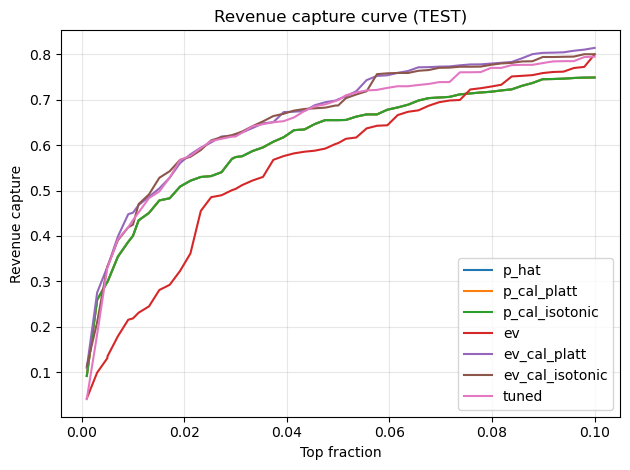

Saved: C:\Users\seony\Desktop\personal_project\purchase_prediction\artifacts\figures\revenue_capture_curve_test.png


In [9]:
# ============ Optional: plot revenue capture curves (TEST) ============
# Keep the plot readable by limiting to a few key strategies
plot_scores = ["p_hat", "p_cal_platt", "p_cal_isotonic", "ev", "ev_cal_platt", "ev_cal_isotonic", "tuned"]

plt.figure()
for sname in plot_scores:
    curve_path = REPORTS_DIR / f"revenue_capture_curve_{sname}.csv"
    c = pd.read_csv(curve_path)
    plt.plot(c["top_frac"], c["revenue_capture"], label=sname)

plt.xlabel("Top fraction")
plt.ylabel("Revenue capture")
plt.title("Revenue capture curve (TEST)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

FIG_OUT = FIGURES_DIR / "revenue_capture_curve_test.png"
plt.savefig(FIG_OUT, dpi=150)
plt.show()
print("Saved:", FIG_OUT)